In [2]:
import apogee.tools.read as apread
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python2.7/site-packages/pkg_resources.py:1054: UserWarning: /home/price-jones/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


In [3]:
data = apread.rcsample()

In [4]:
indx = (data['TEFF']<4800) & (data['TEFF']>4795)

In [5]:
Tdata = data[indx]
len(Tdata)

260

In [6]:
LID = Tdata['LOCATION_ID'][0]
AID = Tdata['APOGEE_ID'][0]

In [7]:
LID

4264

In [8]:
AID

'2M00003071+5606028'

In [9]:
spec, hdr = apread.aspcapStar(LID,AID,ext = 1)

In [10]:
specs = []
for i in range(len(Tdata)):
    spec, hdr = apread.aspcapStar(Tdata['LOCATION_ID'][i],Tdata['APOGEE_ID'][i])
    specs.append(spec)

In [11]:
specs = np.array(specs)

In [12]:
specs

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [18]:
def get_spectra(data):
    """
    Returns spectra and header information for each object specified in data
    
    data:    labels for a subset of the APOGEE survey
    """
    specs = []
    hdrs = []
    for i in range(len(data)):
        spec,hdr = apread.aspcapStar(data['LOCATION_ID'][i],data['APOGEE_ID'][i])
        specs.append(spec)
        hdrs.append(hdr)
    return np.array(specs),np.array(hdrs)

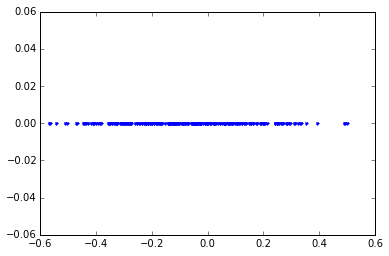

In [17]:
plt.plot(Tdata['METALS'],specs[:,6296],'.')

In [45]:
def slice_plot(sliceinfo,plotids,pix = None, wv = None):
    """
    Creates plots of label value for labels in plot ids vs value at a given pixel pix for 
    some subset of the red clump sample specified by slice info.
    
    sliceinfo:  a list that holds the following:
                [key of label to slice in, lower slice limit and upper slice limit]
    plotids:    a list of keys that indicate labels we wish to plot against pixel value
    pix:        pixel value at which to plot (integer or array) - used by default over wv
    wv:         optional specification of wavelength value instead of pixel 
                (not yet implemented, and program defaults to pixel if both are given)
    """
    if pix == None and wv == None:
        print 'Please specify a pixel or a wavelength'
    if pix != None and wv != None:
        print 'Defaulting to pixel value'
        wv = None
    if pix == None and wv != None:
        # Add here some function to convert from pixel to wavelength
        # this surely exists somewhere in apogee
        # For now default to a particular pixel value: 3000
        pix = 3000
    data = apread.rcsample()
    label, lower, upper = sliceinfo
    indx = (data[label]>lower) & (data[label]<upper)
    data = data[indx]
    specs,hdrs = get_spectra(data)
    plt.figure(figsize = (10,8))
    if isinstance(pix,(int,float)):
        for l in range(len(plotids)):
            plt.subplot(len(plotids),1,l+1)
            plt.plot(data[plotids[l]],specs[:,pix],'.')
            smin = min(specs[:,pix])
            smax = max(specs[:,pix])
            if smin != smax:
                plt.ylim(smin-0.1,smax+0.1)
            plt.ylabel('Pixel Value')
            plt.xlabel(plotids[l])
            if l == 0:
                plt.title('Pixel {0}'.format(pix))
    elif isinstance(pix,(list, np.ndarray)):
        for p in range(len(pix)):
            for l in range(len(plotids)):
                plt.subplot2grid((len(plotids),len(pix)),(l,p))
                plt.plot(data[plotids[l]],specs[:,pix[p]],'.')
                smin = min(specs[:,pix[p]])
                smax = max(specs[:,pix[p]])
                if smin != smax:
                    plt.ylim(smin-0.1,smax+0.1)
                plt.ylabel('Pixel Value')
                plt.xlabel(plotids[l])
                if l == 0:
                    plt.title('Pixel {0}'.format(pix[p]))
    plt.tight_layout()
            
    
    

In [ ]:
slice_plot(['LOGG',2.75,2.80],['METALS','TEFF','ALPHAFE'],pix = [300,6000,2000])